In [ ]:
import sys
import os
current_dir = os.path.abspath(os.getcwd())
parent_dir = os.path.dirname(current_dir)
sys.path.append(os.path.join(parent_dir, 'scripts'))
from train_ensemble import train_ensemble
from train_gpt2 import train_gpt2
from sampling import rejection_sampling, MH_sampling
import matplotlib.pyplot as plt
from data_processing import load_data
import pandas as pd

In [20]:
training_data_pth = "https://raw.githubusercontent.com/SimonDufLab/IFT6390--H2023--Project/main/training_data.csv"
test_data_pth = "https://raw.githubusercontent.com/SimonDufLab/IFT6390--H2023--Project/main/test_data.csv"

In [23]:
Train, Test = load_data(training_data_pth, test_data_pth)

In [26]:
Data = pd.concat([Train, Test], ignore_index=True)

/tmp/ipykernel_226986/3958099929.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


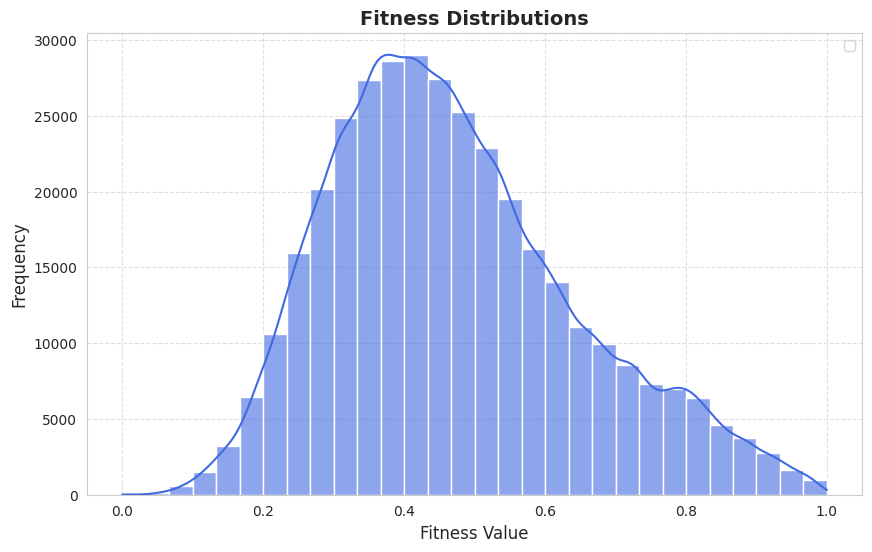

In [31]:
# Set the Seaborn style for better aesthetics
sns.set_style("whitegrid")

# Create the figure
plt.figure(figsize=(10, 6))

# Plot histograms with KDE for all three distributions
sns.histplot(Data["fitness"], bins=30, kde=True, color="royalblue", alpha=0.6)

# Formatting the plot
plt.xlabel("Fitness Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Fitness Distributions", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Show the plot
plt.show()


**1: Building our special evaluation function**

*Architecture du modèle avec un modèle a priori aléatoire*

Le modèle utilisé pour l'évaluation de la qualité des séquences générées est composé de deux sous modèle, le "trainable" $t_i$ qui s'entraine par le dataset d'entrainement, et l'a priori aléatoire $p_i$ quest génrérer aléatoirement et reste inchangé pour un modèle $g_i$  de l'ensemble des modèles de l'ensemble. Cette technique est basée sur le papier [Randomized Prior Functions
 for Deep Reinforcement Learning](https://arxiv.org/pdf/1806.03335)

In [3]:
ensemble_models, records = train_ensemble(training_data_pth, test_data_pth)

Training model 1 
Training model 2 
Training model 3 
Training model 4 
Training model 5 
Training model 6 


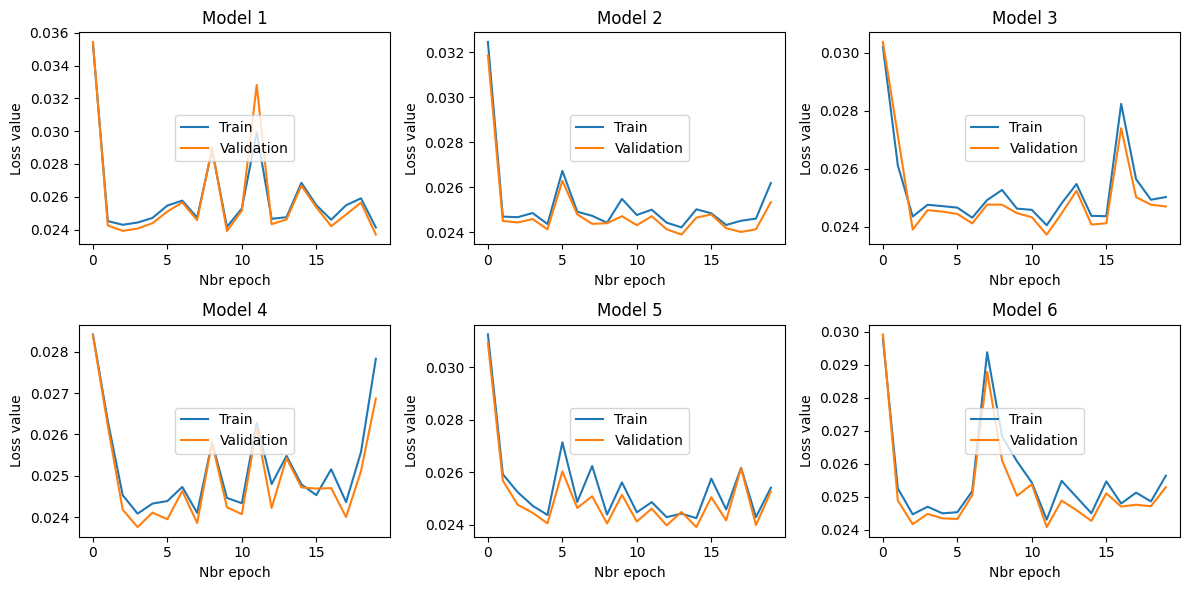

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

# Plot each figure in a separate subplot
for i, record in enumerate(records):
    ax = axs[i // 3, i % 3]
    ax.plot(record['train_loss'])
    ax.plot(record['test_loss'])
    ax.set_title(f"Model {i+1}")
    ax.set_ylabel('Loss value')
    ax.set_xlabel('Nbr epoch')
    ax.legend(['Train', 'Validation'], loc='center')

fig.tight_layout()
plt.show()

In [10]:
gpt2, tokenizer = train_gpt2(training_data_pth, test_data_pth)

Model found at ../models/GPT2, loading it...


In [ ]:
RS = rejection_sampling('AGTGAGCA', 500, gpt2, tokenizer, ensemble_models, 6)
MH = MH_sampling('AGTGAGCA', 500, gpt2, tokenizer, ensemble_models, 6)

In [13]:
RS

,bindings,fitness
344,AGTGAGCACACTATCA,0.797204
569,AGTGAGCAACGATACA,0.793600
0,AGTGAGCACACTATAC,0.743865
216,AGTGAGCACACTATAC,0.743865
291,AGTGAGCACACTATAC,0.743865
...,...,...
12,AGTGAGCAGCGCTGAC,0.286228
342,AGTGAGCAACGCCGAC,0.286227
577,AGTGAGCAACGCCGAC,0.286227
38,AGTGAGCAACGCCGAC,0.286227


In [12]:
MH

,full-seq,fitness
204,AGTGAGCATATATCTG,0.971220
121,AGTGAGCATCTGATAC,0.940880
169,AGTGAGCAGTATCACA,0.926033
278,AGTGAGCATATCCGGA,0.909172
51,AGTGAGCAGTGATACT,0.902708
...,...,...
380,AGTGAGCATGTGGCAC,0.296623
8,AGTGAGCAGCTCCGAC,0.293265
363,AGTGAGCACGACGGTC,0.287034
256,AGTGAGCAGGCGACTC,0.286332


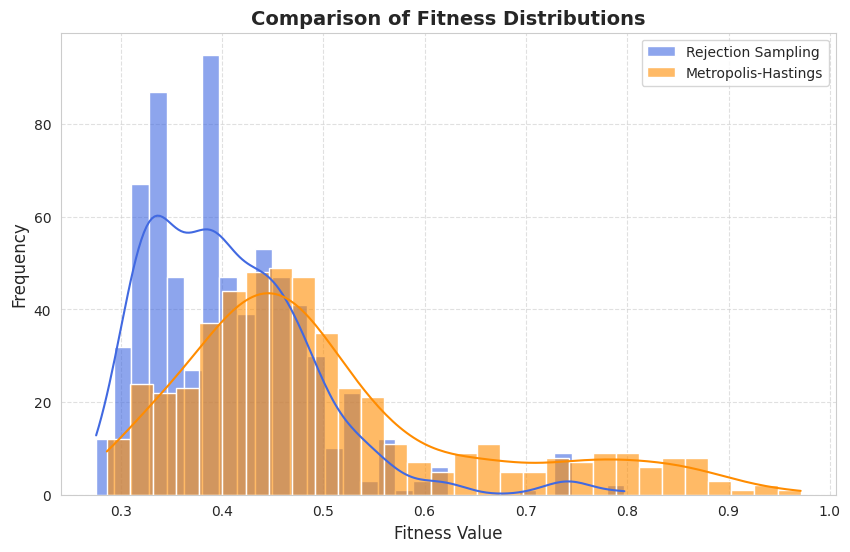

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the Seaborn style for better aesthetics
sns.set_style("whitegrid")

# Create the figure
plt.figure(figsize=(10, 6))

# Plot histograms with KDE for all three distributions
sns.histplot(RS["fitness"], bins=30, kde=True, color="royalblue", label="Rejection Sampling", alpha=0.6)
sns.histplot(MH["fitness"], bins=30, kde=True, color="darkorange", label="Metropolis-Hastings", alpha=0.6)

# Formatting the plot
plt.xlabel("Fitness Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Comparison of Fitness Distributions", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Show the plot
plt.show()


#  Comparaison entre Rejection Sampling et Metropolis-Hastings

##  Répartition des valeurs de fitness
- **Rejection Sampling (RS)** : La distribution est **concentrée sur des valeurs plus faibles**, avec un pic marqué autour de **0.3-0.4**. Cette méthode a tendance à **rejeter une grande partie des échantillons**, ce qui limite l'exploration des valeurs plus élevées.
- **Metropolis-Hastings (MH)** : La distribution est **plus étalée**, avec un pic légèrement plus haut (**~0.4-0.5**) et une meilleure couverture des **valeurs élevées de fitness (jusqu'à 0.9)**. Cela montre que cette méthode explore plus efficacement l’espace des solutions.

##  Exploration et diversité des solutions
- **RS est plus conservateur**, en acceptant uniquement certains échantillons, ce qui se traduit par une distribution plus contrainte.
- **MH couvre une plage plus large**, ce qui lui permet d'explorer des solutions avec des valeurs de fitness plus élevées.

##  Efficacité et biais potentiel
- **Rejection Sampling** semble introduire un **biais** en favorisant une certaine plage de valeurs, ce qui pourrait limiter la qualité des solutions si les valeurs élevées sont trop rares.
- **Metropolis-Hastings** propose un **meilleur compromis entre exploration et exploitation**, car il suit une **chaîne de Markov** qui lui permet d’explorer progressivement de nouvelles solutions.

##  Conclusion
- **Si l'objectif est d'échantillonner avec un bon équilibre entre exploration et exploitation, Metropolis-Hastings est plus adapté.**  
- **Si on veut filtrer fortement les échantillons pour ne garder que des valeurs bien définies, Rejection Sampling peut être plus efficace, mais au prix d’une diversité réduite.**  

 **Dans un contexte d'optimisation, Metropolis-Hastings semble plus prometteur pour trouver des solutions à haute fitness.**
    
 L’application de l’apprentissage machine à la synthèse automatique de nouveaux médicaments représente un domaine d’avenir particulièrement prometteur. Ce contexte met en lumière les similitudes entre la génération de molécules et les approches utilisées en modélisation du langage, telles que celles derrière des modèles comme ChatGPT.

L’objectif ne se limite pas à une simple reproduction des données existantes, comme dans le cas de la génération de texte, mais vise plutôt à orienter l’échantillonnage vers les régions les plus prometteuses du point de vue biologique et pharmaceutique. Cette approche allie donc des méthodes d’apprentissage profond à des objectifs spécifiques d’optimisation, favorisant ainsi la découverte de molécules innovantes avec des propriétés thérapeutiques ciblées.

Ce contexte illustre également la convergence entre les modèles génératifs appliqués au Traitement Automatique du Langage Naturel (TALN/NLP) et ceux utilisés en génération de séquences moléculaires, soulignant l’importance des avancées en intelligence artificielle pour des domaines aussi variés que la santé et la biotechnologie. **